In [1]:
# math reference
# https://tel.archives-ouvertes.fr/tel-00818032/document
# https://www.researchgate.net/publication/297661784_On_Holo-Hilbert_spectral_analysis_a_full_informational_spectral_representation_for_nonlinear_and_non-stationary_data

In [2]:
!pip install numpy matplotlib scipy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 942.4 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.0 MB/s eta 0:00:00


In [3]:
'''Load libs'''
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import hilbert

from EMD import EMD, plot_imfs

plt.style.use('bmh')
np.random.seed(42)

# Generate data

In [4]:
# Generate true signal
n_time = 1000
fs = 1
t = np.linspace(0, n_time, n_time)
signal = np.sin(t * 0.04)

# Generate noise signal
noise = np.random.uniform(-0.5,0.5,n_time)
signal_add_noise = signal + noise
signal_mul_noise = signal * noise

/tmp/ipykernel_44808/476330968.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


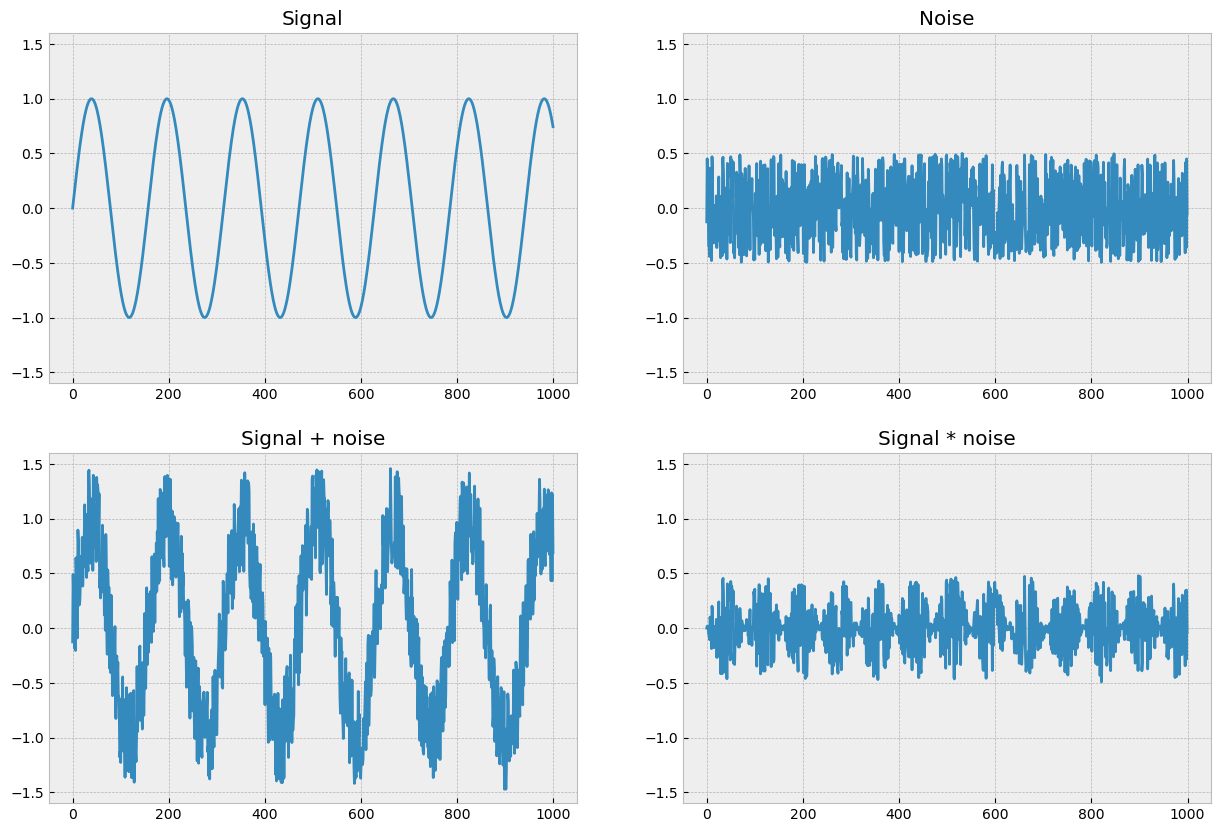

In [5]:
titles = [['Signal', 'Noise'], ['Signal + noise', 'Signal * noise']]
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(signal)
ax[0,1].plot(noise)
ax[1,0].plot(signal_add_noise)
ax[1,1].plot(signal_mul_noise)

for i in range(2):
    for j in range(2):
        ax[i,j].set_ylim(-1.6,1.6)
        ax[i,j].set_title(titles[i][j])
fig.show()

# Signal analysis

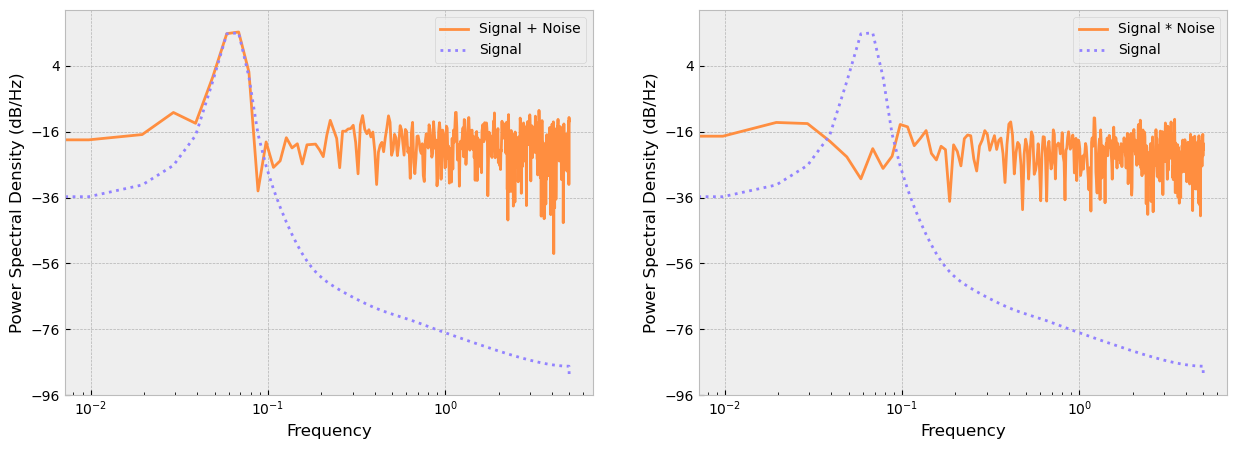

In [6]:
# Power Spectral Density
nfft = 1024
dt=0.1

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].psd(signal_add_noise, nfft, 1/dt, label='Signal + Noise', c='#FF8E40')
ax[0].psd(signal, nfft, 1/dt,label='Signal', ls=':',c='#9282FF')
ax[0].set_xscale('log')
ax[0].set_ylim(-96, 21)
ax[0].legend()

ax[1].psd(signal_mul_noise, nfft, 1/dt, label='Signal * Noise',c='#FF8E40')
ax[1].psd(signal, nfft, 1/dt,label='Signal', ls=':', c='#9282FF')
ax[1].set_xscale('log')
ax[1].set_ylim(-96, 21)
ax[1].legend()
plt.show()

# Empirical Mode Decomposition  
The EMD method is a necessary step to reduce any given data into a collection of intrinsic mode functions (IMF) to which the Hilbert spectral analysis can be applied.

1. Identify all the local extrema in the test data.
2. Connect all the local maxima by a cubic spline line as the upper envelope.
3. Repeat the procedure for the local minima to produce the lower envelope.

**max_imf** - number of Intrinsic mode functions (IMF)  
**min_std** - std of final function. Stoping condition

In [7]:
def plot_imfs(imfs, w=20, h=10):
    fig, ax = plt.subplots(len(imfs), 1, figsize=(w,h))
    for i in range(len(imfs)):
        ax[i].plot(imfs[i])
    fig.tight_layout()

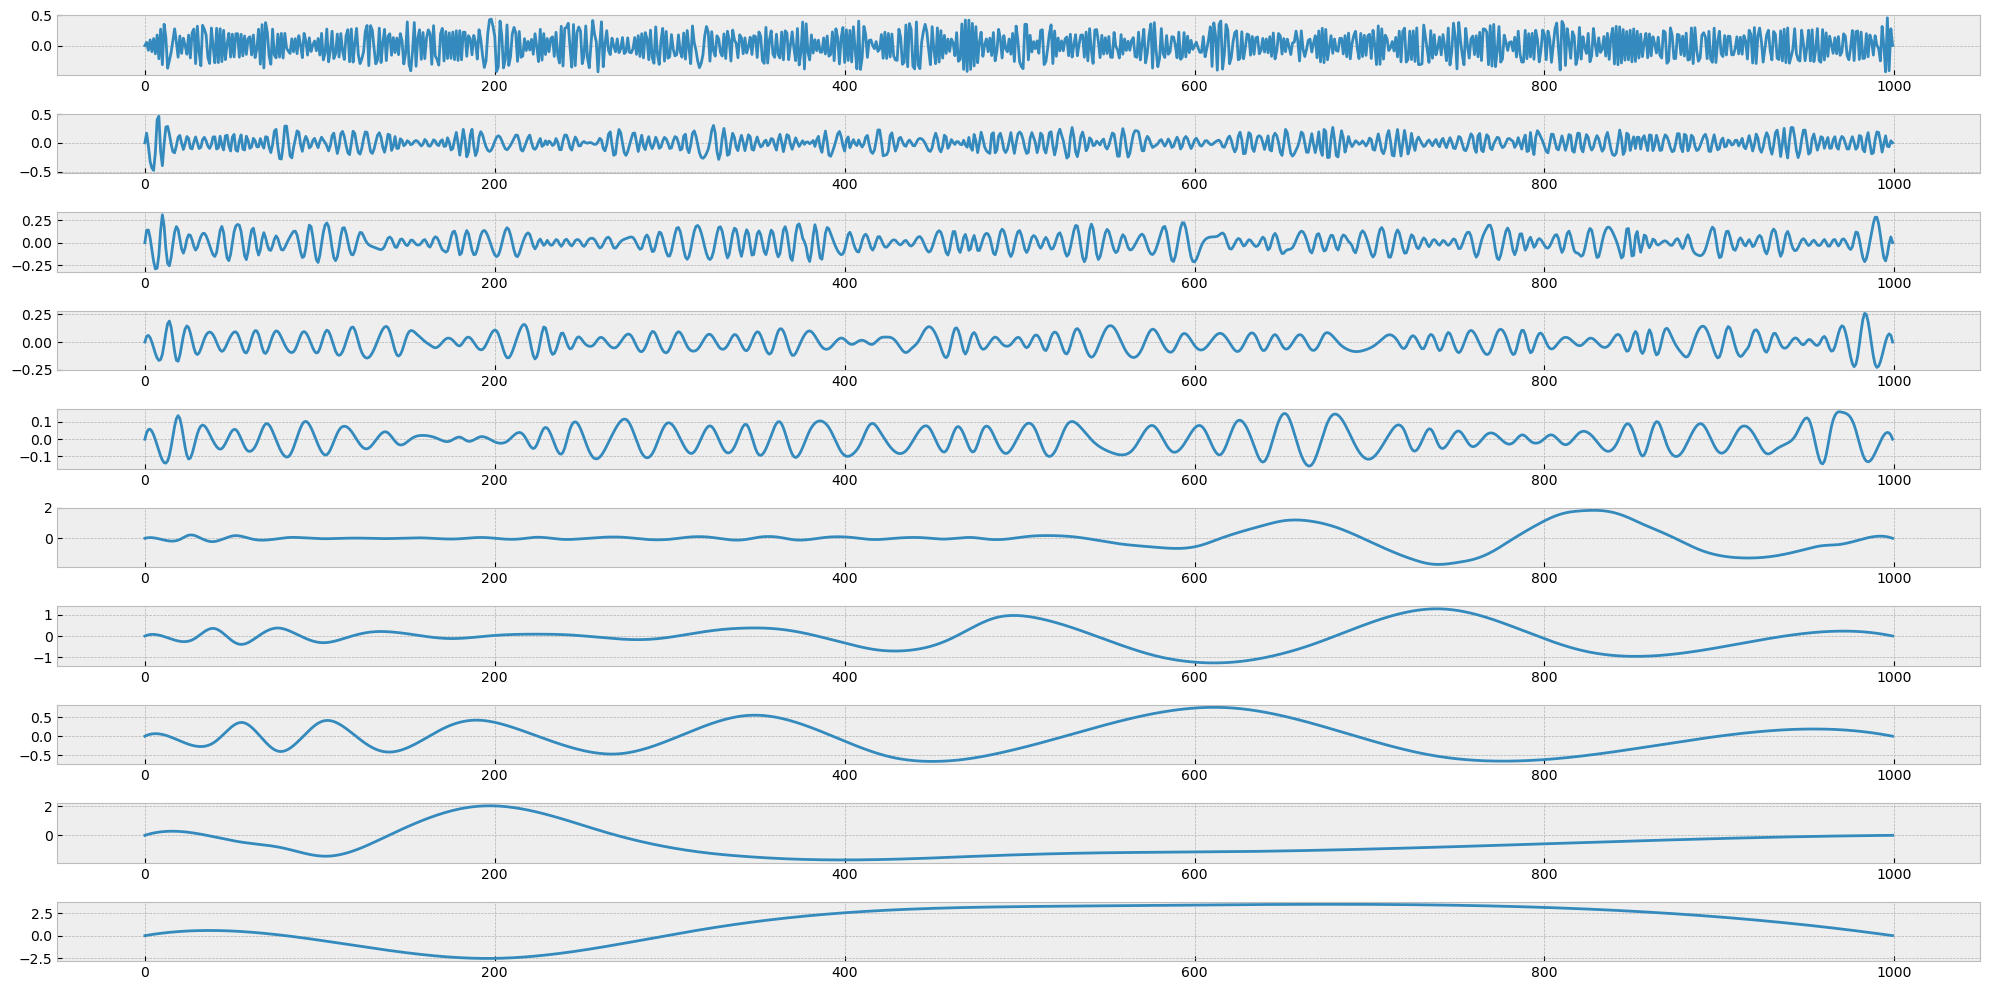

In [8]:
# First IMFs

N_IMFS = 1000 

imfs_add = EMD(signal_add_noise, max_imfs=N_IMFS)
imfs_mult = EMD(signal_mul_noise, max_imfs=N_IMFS)

# preview IMFS
plot_imfs(imfs_add[:10])


In [14]:
def get_insta_values(imfs):
    instantaneous_frequencies = []
    instantaneous_phases = [] # also known as Omega
    for imf in tqdm(imfs):
        hilbert_transform = hilbert(imf)

        inst_phase = np.unwrap(np.angle(hilbert_transform))
        inst_freq = np.diff(inst_phase)

        instantaneous_frequencies += [inst_freq]
        instantaneous_phases += [inst_phase]
    return np.array(instantaneous_frequencies), np.array(instantaneous_phases)[:,1:]

add_if, add_ip = get_insta_values(imfs_add)
mult_if, mult_ip = get_insta_values(imfs_mult)


100%|██████████| 1000/1000 [00:00<00:00, 6390.41it/s]


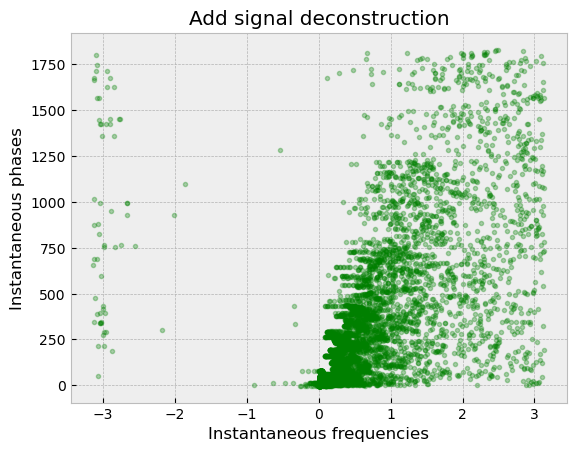

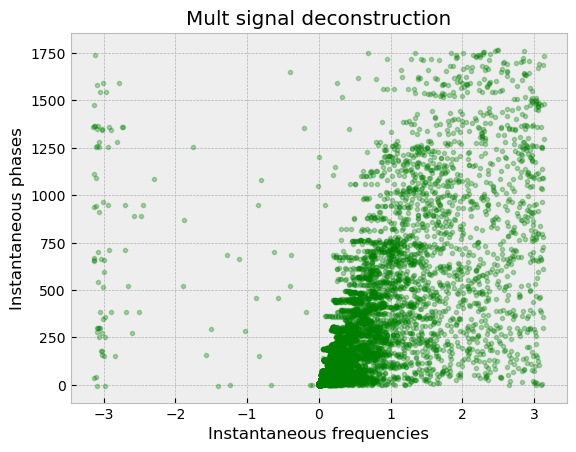

In [15]:
def plot_me(IF, IP, title=''):
    X = []
    Y = []
    N = len(IF)
    for j in range(N):
        for i in range(len(IF[j])):
            X += [IF[j][i]]
            Y += [IP[j][i]]
    plt.figure()
    plt.plot(X, Y, '.g', alpha=0.3)
    plt.xlabel('Instantaneous frequencies')
    plt.ylabel('Instantaneous phases')
    plt.title(title)

plot_me(add_if, add_ip, title='Add signal deconstruction')
plot_me(mult_if, mult_ip, title='Mult signal deconstruction')

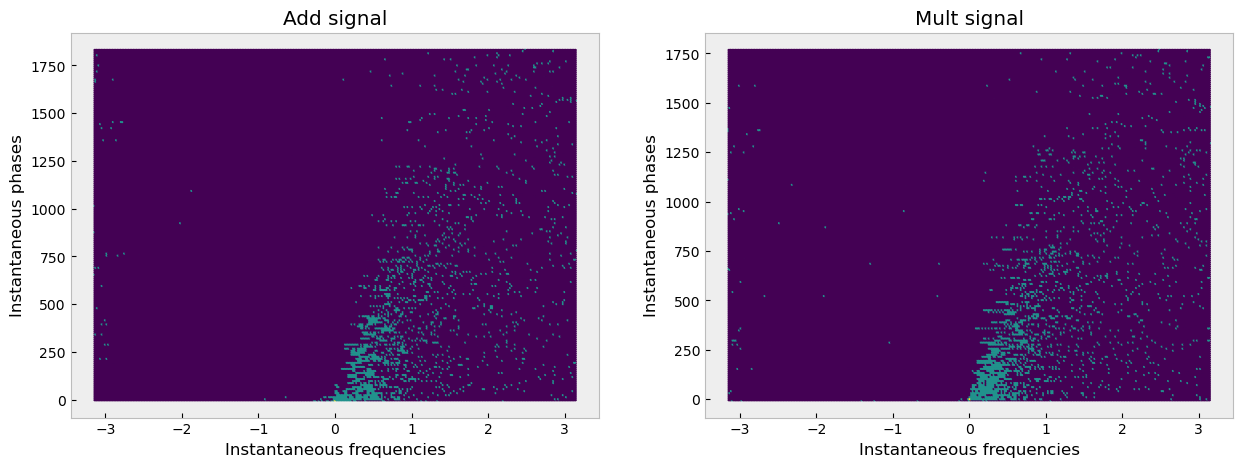

In [77]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
h0 = ax[0].hexbin(add_if, add_ip, gridsize=300, bins=3)
h1 = ax[1].hexbin(mult_if, mult_ip, gridsize=300, bins=3)
for i in range(2):
    ax[i].set_xlabel('Instantaneous frequencies')
    ax[i].set_ylabel('Instantaneous phases')

ax[0].set_title('Add signal')
ax[1].set_title('Mult signal')

ax[0].grid(False);ax[1].grid(False)


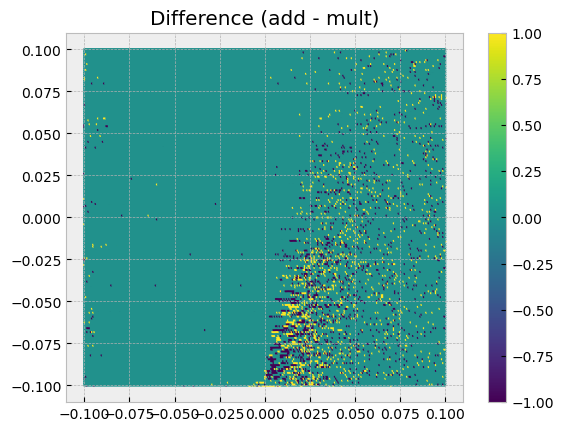

In [79]:
# Difference
h = plt.hexbin(np.zeros_like(add_if), np.zeros_like(add_ip), gridsize=300, bins=3, vmin=-1, vmax=1)
h.set_array(h0.get_array() - h1.get_array())
plt.title('Difference (add - mult)')
plt.colorbar()
plt.show()